In [25]:
import torch
import random

In [41]:
# Define the original tensor
#original_tensor = torch.tensor([1, 2, 3])

# Define the size
class_num = 5
size = 3
batch_size = 5

label = torch.randint(0, class_num-1, (batch_size,))
original_tensor = torch.randint(0, 10, (batch_size, 3))

# Create a new tensor with each element repeated 'size' times
repeated_tensor = original_tensor.repeat_interleave(size).reshape(batch_size, size, -1)
print(label)
#print(repeated_tensor)
#repeated_tensor = repeated_tensor.reshape(class_num, size, 1)

label_idx = list(range(len(label)*size))
random.shuffle(label_idx)
#label_shuffle = torch.tensor(label[label_idx])
print(label_idx)



tensor([2, 2, 1, 3, 1])
[0, 8, 2, 13, 1, 4, 9, 5, 11, 3, 12, 10, 6, 14, 7]


In [44]:
import torch
import random
from itertools import groupby

# 元のテンソル
original_tensor = torch.tensor([1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 2, 2, 2])

# テンソルをリストに変換
original_list = original_tensor.tolist()

# 同じ数字のセットをサブリストに分割し、そのインデックスも取得
grouped_values = []
grouped_indices = []
for value, group in groupby(enumerate(original_list), key=lambda x: x[1]):
    group = list(group)
    grouped_values.append([x[1] for x in group])  # 値
    grouped_indices.append([x[0] for x in group])  # インデックス

# 値のサブリストとインデックスを同じ順番でシャッフル
combined = list(zip(grouped_values, grouped_indices))
random.shuffle(combined)

# シャッフルされたサブリストを結合
shuffled_values = [item for group, _ in combined for item in group]
shuffled_indices = [idx for _, indices in combined for idx in indices]

# リストを再びテンソルに変換
shuffled_tensor = torch.tensor(shuffled_values)

print("もとのテンソル", original_tensor)
print("シャッフルされたテンソル:", shuffled_tensor)
print("シャッフルされたインデックス:", shuffled_indices)
    

もとのテンソル tensor([1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 2, 2, 2])
シャッフルされたテンソル: tensor([4, 4, 4, 2, 2, 2, 5, 5, 5, 1, 1, 1, 2, 2, 2, 3, 3, 3])
シャッフルされたインデックス: [9, 10, 11, 15, 16, 17, 12, 13, 14, 0, 1, 2, 3, 4, 5, 6, 7, 8]


In [3]:
import torch
from torch import nn
from torch.nn import functional as F

class GaussPertubation(nn.Module):
    def __init__(self, dim=768, aug_time=8):
        super().__init__()
        self.dim = dim
        self.mean = nn.Parameter(torch.zeros(dim))
        self.log_std = nn.Parameter(torch.zeros(dim))
        self.aug_time = aug_time

    def get_noise(self):
        gauss_dist = torch.distributions.Normal(self.mean, self.log_std.exp())
        e = gauss_dist.sample()
        return F.softplus(e)

    def augment(self, x):
        aug_x = []
        print(x.shape)
        for i in range(self.aug_time):
            noise = self.get_noise()
            aug_x.extend(x + noise)
        return torch.stack(aug_x)

    def forward(self, x):
        return self.augment(x)

pertubation = GaussPertubation()

x = torch.randn(1, 768) # batch_size, dim
pertubation(x).shape

x.mean()

torch.Size([1, 768])


tensor(-0.0040)

Text(0.5, 1.0, 'text entropy')

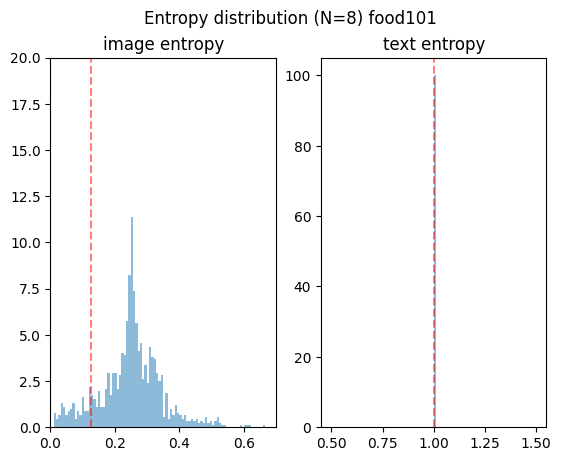

In [76]:
import pickle
import torch

dataset = "food101"
path = f"/home/yhiro/work/AWT/AWT_few_shot/MM_Adapter/output/{dataset}/AWT/vit_b16_1_2_4_shot_check_ent_1shots/seed3"
epoch_num = 20
aug_num_image = 8
aug_num_text = 1

image_weights = []
text_weights = []
for i in range(epoch_num):
    with open(f"{path}/image_weights_ep_{i}.pkl", "rb") as f:
        data = pickle.load(f)
        image_weights.extend(data.reshape(-1))
    with open(f"{path}/text_weights_ep_{i}.pkl", "rb") as f:
        data = pickle.load(f)
        text_weights.extend(data.reshape(-1))

# plot histogram
import matplotlib.pyplot as plt
import numpy as np

vline_image = 1.0 / aug_num_image
vline_text = 1.0 / aug_num_text

fig, ax = plt.subplots(1, 2)
ax = ax.ravel()
fig.suptitle(f"Entropy distribution (N={aug_num_image}) {dataset}")
ax[0].hist(image_weights, bins=100, alpha=0.5, label="image", density=True)
ax[0].axvline(vline_image, color='r', alpha=0.5, linestyle='--')
ax[0].set_title("image entropy")
ax[0].set_ylim(0, 20)
ax[0].set_xlim(0, 0.7)
ax[1].hist(text_weights, bins=100, alpha=0.5, label="text", density=True)
ax[1].axvline(vline_text, color='r', alpha=0.5, linestyle='--')
ax[1].set_title("text entropy")

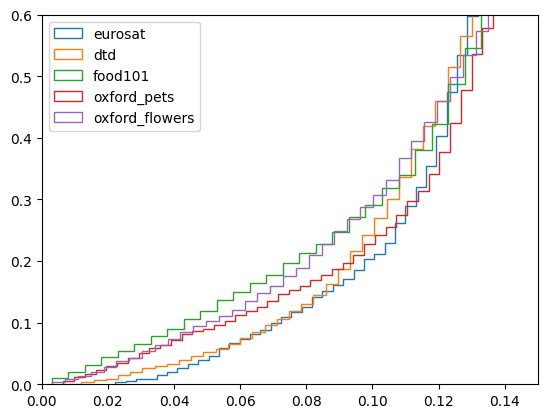

In [2]:
import pickle
import matplotlib.pyplot as plt

datasets = ["eurosat", "dtd", "food101", "oxford_pets", "oxford_flowers"]

for dataset in datasets:
    path = f"/home/yhiro/work/AWT/AWT_few_shot/MM_Adapter/output/{dataset}/AWT/vit_b16_1_2_4_shot_check_ent_1shots/seed1"
    epoch_num = 20
    aug_num_image = 8
    
    image_weights = []
    for i in range(epoch_num):
        with open(f"{path}/image_weights_ep_{i}.pkl", "rb") as f:
            data = pickle.load(f)
            image_weights.extend(data.reshape(-1))

    # plot cumulative distribution
    plt.hist(image_weights, bins=100, density=True, histtype="step", cumulative=True, label=dataset)
plt.xlim(0, 0.15)
plt.ylim(0, 0.6)
plt.legend()
plt.show()

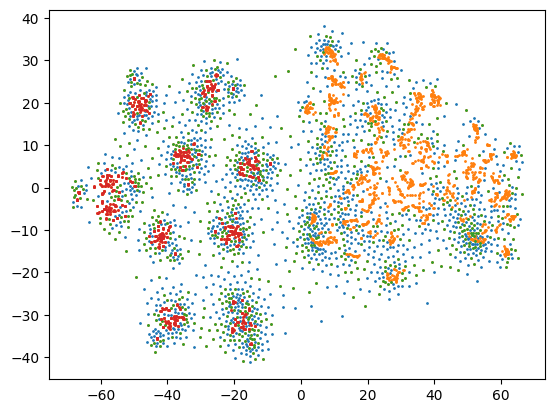

In [2]:
import pickle
import torch
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import numpy as np

dataset = "eurosat"
path = f"/home/yhiro/work/AWT/AWT_few_shot/MM_Adapter/output/{dataset}/AWT_RESAMPLE/vit_b16_1_2_4_shot_4shots/seed1"
epoch_num = 20

image_features = []
text_features = []
image_features_mod = []
text_features_mod = []
label = []

for i in range(10,20):
    with open(f"{path}/img_feat_stu_{i}.pkl", "rb") as f:
        data = pickle.load(f)
        image_features.extend(data)
    with open(f"{path}/text_feat_stu_{i}.pkl", "rb") as f:
        data = pickle.load(f)
        text_features.extend(data)
    with open(f"{path}/img_feat_mod_{i}.pkl", "rb") as f:
        data = pickle.load(f)
        image_features_mod.extend(data)
    with open(f"{path}/text_feat_mod_{i}.pkl", "rb") as f:
        data = pickle.load(f)
        text_features_mod.extend(data)
    with open(f"{path}/label_{i}.pkl", "rb") as f:
        data = pickle.load(f)
        label.extend(data)

# concat all numpy features
image_features_all = np.concatenate([image_features_mod, image_features], axis=0)
text_features_all = np.concatenate([text_features_mod, text_features], axis=0)
#mm_features_all = np.concatenate([image_features, text_features], axis=0)
all_features = np.concatenate([image_features_all, text_features_all], axis=0)

# t-SNE

reducer = TSNE(n_components=2, random_state=0)
#reducer = umap.UMAP(random_state=0)

all_features_tsne = reducer.fit_transform(all_features)

image_features_all_tsne = all_features_tsne[:len(image_features_all)]
image_features_mod_tsne = all_features_tsne[:len(image_features_mod)]
image_features_all_tsne = all_features_tsne[len(image_features_mod):]

text_features_all_tsne = all_features_tsne[len(image_features_all):]
text_features_mod_tsne = text_features_all_tsne[:len(text_features_mod)]
text_features_all_tsne = text_features_all_tsne[len(text_features_mod):]

fig, ax = plt.subplots()
ax.scatter(image_features_mod_tsne[:, 0], image_features_mod_tsne[:, 1], label="image mod", s=1)
ax.scatter(image_features_all_tsne[:, 0], image_features_all_tsne[:, 1], label="image all", s=1)
ax.scatter(text_features_mod_tsne[:, 0], text_features_mod_tsne[:, 1], label="text mod", s=1)
ax.scatter(text_features_all_tsne[:, 0], text_features_all_tsne[:, 1], label="text all", s=1)

#all_features_tsne = all_features_tsne.reshape(2, 2, -1, 2)

# i:0, j:0 -> image feature and resampling
# i:0, j:1 -> image feature and original
# i:1, j:0 -> text feature and resampling
# i:1, j:1 -> text feature and original

# # plot
# fig, ax = plt.subplots()
# for i in range(2):
#     for j in range(2):
#         ax.scatter(all_features_tsne[i, j, :, 0], all_features_tsne[i, j, :, 1], label=f"mod{i} stu{j}", s=1)
# ax.legend()

# # plot
# fig, ax = plt.subplots()
# for i in range(2):
#     ax.scatter(all_features_tsne[i, :, 0], all_features_tsne[i, :, 1], label=f"mod{i} stu0", s=1)

In [5]:
all_features_tsne.shape

(2, 2, 1600, 2)

In [9]:
text_features_mod

[array([-6.1865e-01, -6.6504e-01, -5.9180e-01, -1.4434e+00,  4.4971e-01,
        -5.9375e-01, -9.2822e-01, -9.8877e-01, -3.1036e-02, -4.8291e-01,
         3.7817e-01,  1.1621e+00,  1.5449e+00,  2.0081e-02, -1.2969e+00,
         1.1318e+00, -6.3037e-01,  1.6416e+00, -6.2646e-01, -5.0195e-01,
         1.1934e+00, -3.0933e-01,  3.1952e-02, -7.7576e-02,  1.0840e+00,
        -6.0889e-01,  1.8713e-01,  6.1523e-01,  3.4351e-01,  3.6743e-01,
         3.4424e-01, -3.5229e-01, -3.0127e-01,  2.8223e-01,  6.7285e-01,
        -9.3018e-01,  2.2253e-01,  6.5088e-01,  6.7383e-01, -1.5098e+00,
         1.3379e+00,  2.3613e+00,  2.4017e-02, -1.5010e+00,  1.1543e+00,
        -5.6152e-01,  9.8438e-01, -1.0605e+00, -1.5039e+00,  7.4023e-01,
        -1.8818e+00, -4.3188e-01,  1.0107e+00,  3.3905e-02,  1.2734e+00,
         1.3354e-01, -1.8936e+00, -1.3457e+00,  1.0059e+00,  9.4043e-01,
         6.7871e-01, -6.4209e-01,  1.7041e+00, -2.4292e-01,  2.6270e-01,
        -8.2581e-02, -1.3418e+00,  3.3905e-02, -1.5